In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Import all AI classes and helper functions
from helper import (
    RandomAI, RuleBasedAI, QLearningAI, RLHF_AI,
    BiasedHumanSimulator,
    trainQLearning, demonstrateRewardMisspecification, compareMoveDitributions,
    visualizeUserRLHF,
    playAgainstAI, measurePerformance, runPerformanceBenchmark
)
from ticTacToe import Model, View, Controller, Player

## Tic Tac Toe - Agents Learning to Play Games

Over the past couple of decades, we have seen AI's become super-human when it comes to playing games. With the likes of AlphaGo beating the best Go players in the world, games have been the perfect environment to build cutting edge AI technology.

In this worksheet, we will take a tour through the history of AI and see how a variety of AI methods developed with the aim of developing an agent that plays Tic Tac Toe.

#### Contents:
- Building a sandbox environment
    - Tic Tac Toe implementation
- Agents interacting with enviornments
    - Principles of reinforcement learning (RL)
    - Building a random baseline
- Classical AI
    - Rule-based intelligence
- Deep Learning Revolution
    - Basic methods of modern reinforcement learning 
        - Q Learning
        - Learning from trial and error
- Alignment and Safety of Agentic AI
    - Reinforcement Learning from Human Feedback
        - Learning user-preferred strategies
    - Reward misspecification

## 1. Building a Sandbox Environment 
We have provided a minimal implementation of tic tac toe using the model-view-controller pattern for making a game. Run the cell below to play the game. The game is played through the command line and you can enter moves by specifying the coordinates on the game grid

In [ ]:
#the more the size of the grid, the more the complexity of the game!
game = Controller(3)
game.playGame()

## 2. Agents Interacting with Environments

In reinforcement learning, an **agent** learns by interacting with an **environment**. The agent observes the current **state**, takes an **action**, and receives **feedback** (reward or new state). Over time, the agent learns which actions lead to better outcomes.

#### Building a Random Baseline
We will now create the simplest AI possible. We will find all the free spaces on the board using the **getAvailableMoves()** function and then choose a random move using the **getMove()** function.

### Test Random AI Performance

Now let's see how well the Random AI performs! Since it just picks random moves, it serves as our **baseline** - any smarter AI should beat this.

In [4]:
# Test Random AI vs Random AI (our baseline)
# When two random players compete, X has an advantage (goes first) but it's roughly even

print("RANDOM AI BASELINE PERFORMANCE")
print("=" * 50)
print("Random AI vs Random AI - this is our baseline!\n")

random_results = measurePerformance(ai_type="random", num_games=200, player_ai_type="random")

RANDOM AI BASELINE PERFORMANCE
Random AI vs Random AI - this is our baseline!


Measuring random AI performance over 200 games...
Playing against: random AI

  Progress: 20/200 games completed
  Progress: 40/200 games completed
  Progress: 60/200 games completed
  Progress: 80/200 games completed
  Progress: 100/200 games completed
  Progress: 120/200 games completed
  Progress: 140/200 games completed
  Progress: 160/200 games completed
  Progress: 180/200 games completed
  Progress: 200/200 games completed

PERFORMANCE RESULTS: RANDOM AI
  Games played: 200
  Opponent: random AI
--------------------------------------------------
  Wins:     105 (52.5%)
  Losses:    64 (32.0%)
  Ties:      31 (15.5%)


## 3. Classical AI

Before the dawn of deep learning, most artificial intelligence systems were either **rule-based** or **search-based**. 

Rule based AI relies on humans providing domain specific knowledge and specifying strategies to help the AI make decisions. The "agent" or AI in this case has this knowledge hard coded and has the capability of executing these strategies. It is interesting to think about whether this is actually an "intelligent" system by today's standards. 

In our toy example, we will expand on the random AI by creating the function **checkWinningMove()** that will check the board to see whether there is a winning move to be played or if the opponent has a winning move. We know that the optimal decision in this case would be to play the winning move or block the opponent. Hence, we can encode this knowledge into our AI. However, if there is no winning move we will choose to make it play randomly.

What are some of the drawbacks to this method you can think of? Especially when it comes to scalability?

### Test Rule-Based AI Performance

Now let's see how our Rule-Based AI performs against the Random baseline. Since it can detect winning moves and block the opponent, it should perform significantly better!

In [5]:
# Test Rule-Based AI vs Random AI
# The rule-based AI should win much more often because it:
# 1. Takes winning moves when available
# 2. Blocks opponent's winning moves

print("RULE-BASED AI PERFORMANCE")
print("=" * 50)
print("Rule-Based AI vs Random AI\n")

rule_results = measurePerformance(ai_type="rule_based", num_games=200, player_ai_type="random")

# Compare to baseline
print(f"\nImprovement over Random baseline:")
print(f"  Random AI win rate:     ~58-60%")
print(f"  Rule-Based AI win rate: {rule_results['win_pct']:.1f}%")
print(f"  Improvement:            +{rule_results['win_pct'] - 58:.1f}%")

RULE-BASED AI PERFORMANCE
Rule-Based AI vs Random AI


Measuring rule_based AI performance over 200 games...
Playing against: random AI

  Progress: 20/200 games completed
  Progress: 40/200 games completed
  Progress: 60/200 games completed
  Progress: 80/200 games completed
  Progress: 100/200 games completed
  Progress: 120/200 games completed
  Progress: 140/200 games completed
  Progress: 160/200 games completed
  Progress: 180/200 games completed
  Progress: 200/200 games completed

PERFORMANCE RESULTS: RULE_BASED AI
  Games played: 200
  Opponent: random AI
--------------------------------------------------
  Wins:     176 (88.0%)
  Losses:     3 (1.5%)
  Ties:      21 (10.5%)

Improvement over Random baseline:
  Random AI win rate:     ~58-60%
  Rule-Based AI win rate: 88.0%
  Improvement:            +30.0%


## 4. The Deep Learning Revolution

As methods of learning like back-propagation were invented, we got smarter AIs that could be much more scalable than rule-based AI by learning through interacting with data and environments to update their internal models of reality.

One of the main areas of growth was reinforcement learning where the agent interacts with a system and uses feedback from the actions it takes to learn. One of the most basic methods of accomplishing this is Q-learning.

#### Creating a "Mental Model" for the AI
The key idea with Q-learning is that we build a table that maps the state of the board and actions that the AI can take with a score of how good the action is given the board. Mathematically we can think of it as given an action $a_i \in A$ and a state of the board $b_j \in B$, we give it a score $Q(a_i, b_j) : A \times B \rightarrow \mathbb{R}$. We can thus build the following matrix:

$$ \begin{bmatrix}
Q(a_1, b_1) & \cdots & Q(a_1, b_j) \\
 \vdots & \ddots & \vdots \\
Q(a_i, b_1) & \cdots & Q(a_i, b_j) 
\end{bmatrix}  $$

#### Getting the AI to Choose the Optimal Actions
The way the AI chooses a move is to first find the board state $b_j$ currently and then find $a_i$ which maximizes the score.

However, sometimes by playing a less optimal move in the short term, we can get to a better state in the long term. This is what we call the **Exploration-Exploitation Tradeoff**. Initially in the game, we want to explore many options but as the game progresses, we want to optimize the moves we make as the number of options decreases.

In order to model this we consider a parameter $\epsilon \in (0,1)$. We can generate a random number $k \in (0,1)$.

- In the case that $k \geq \epsilon$, we will use our Q-table to find the optimal action. This amounts to "exploiting" what we know
- In the case that $k < \epsilon$, we will generate a random action which is the same as "exploring" options.

We will reduce the $\epsilon$ value as we go along in the game as initially, we want to explore as many options as possible but later on we want to exploit our knowledge and play optimally.

#### Learning from Experience
In order to learn the scores, we can get the AI to play the game many times and update the Q-values based on the outcome:
- **Win**: reward = +1 (good moves should be reinforced)
- **Loss**: reward = -1 (bad moves should be discouraged)  
- **Tie**: reward = +0.5 (neutral outcome)

The update rule moves each Q-value toward the reward:
$$Q(s, a) \leftarrow Q(s, a) + \alpha \cdot (reward - Q(s, a))$$

where $\alpha$ is the learning rate. You can think of the learning rate as controlling how much the AI learns from its experience.

### 4.1 Test Q-Learning AI Performance

Now let's train our Q-Learning AI and see how it performs! Unlike the Rule-Based AI which has hard-coded knowledge, the Q-Learning AI must **learn** good strategies through experience.

Q-LEARNING AI PERFORMANCE
Training Q-Learning AI, then testing vs Random AI

Training complete! Results after 3000 games:
  Wins:   2153 (71.8%)
  Losses: 473 (15.8%)
  Ties:   374 (12.5%)
  Q-table size: 2867 state-action pairs learned
  Final epsilon: 0.0249


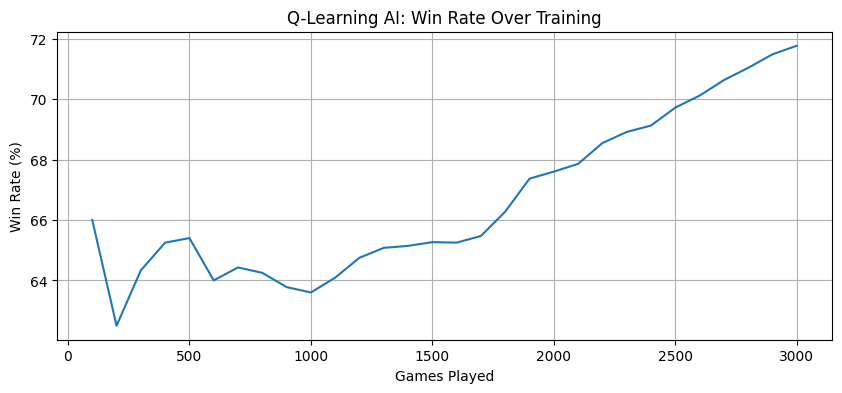


The Q-Learning AI learned from 3000 games!
It discovered 2867 different (state, action) combinations.

Compare to baselines:
  Random AI:      ~58-60% win rate
  Rule-Based AI:  ~90% win rate
  Q-Learning AI:  See results above!


In [ ]:
# Train and test Q-Learning AI vs Random AI
# Watch how the AI improves as it learns from more games!

print("Q-LEARNING AI PERFORMANCE")
print("=" * 50)
print("Training Q-Learning AI, then testing vs Random AI\n")

# Train the Q-Learning AI (this runs many games to learn)
trained_q_ai = trainQLearning(num_games=3000, epsilon=0.5)

print(f"\nThe Q-Learning AI learned from 3000 games!")
print(f"It discovered {len(trained_q_ai.q_table)} different (state, action) combinations.")
print("\nCompare to baselines:")
print(f"  Random AI:      ~58-60% win rate")
print(f"  Rule-Based AI:  ~90% win rate")
print(f"  Q-Learning AI:  See results above!")

## 5. RLHF - Reinforcement Learning from Human Feedback

There are plenty of ways that reinforcement learning can go wrong. In our case, our reward function was to award points for winning and decrease points for losing. However, we never specified **how** we wanted the AI to play. Although this may not seem harmful in this toy example, in the real world this means that the AI could choose a potentially harmful method of "winning" or getting the reward and learn misaligned behaviours. 

This is why we integrate human feedback into the learning loop using **Reinforcement Learning from Human Feedback (RLHF)**. Although this is normally much more complex with regards to modern AI, in our toy model, we will do RLHF by:
1. Given a board state, generate 2 possible moves
2. Show both options to the human and ask the human to pick which move they prefer
3. Update the preference scores: **+1** for the preferred move, **-1** for the rejected move

This allows us to make the reward function based on human preferences in order to align the AI model. Can you think about all the ways this could fail?

### Try It Yourself: Train an RLHF AI with YOUR Preferences!

Now it's your turn to be the human in the loop! Run the cell below to interactively train an AI based on YOUR move preferences. 

You'll be shown random board states with two possible moves, and you pick which one you think is better. After training, we'll test how well your AI performs!

In [ ]:
# INTERACTIVE RLHF TRAINING
# Run this cell to train an AI with YOUR preferences!
#
# You'll be shown board positions and asked to pick between two moves.
# Try to pick moves that you think will help win the game!

# Create a fresh RLHF AI for you to train
my_rlhf_ai = RLHF_AI(model=None, playerType="X", learning_rate=0.3)

# Train with your preferences (change num_comparisons to do more/fewer)
print("="*60)
print("INTERACTIVE RLHF TRAINING")
print("="*60)
print("\nYou will be shown board positions with two possible moves.")
print("Enter 'A' or 'B' to pick the better move, or 'skip' to skip.")
print("Try to pick strategically good moves!\n")

my_rlhf_ai.train(num_comparisons=10)  # Change this number to train more!

INTERACTIVE RLHF TRAINING

You will be shown board positions with two possible moves.
Enter 'A' or 'B' to pick the better move, or 'skip' to skip.
Try to pick strategically good moves!


RLHF TRAINING SESSION
You will be shown board positions with two possible moves.
Pick which move you think is BETTER.
Your preferences will train the AI!


--- Comparison 1/10 ---

CURRENT BOARD:
    0   1   2
  +---+---+---+
0 | + | O | + |
  +---+---+---+
1 | O | + | X |
  +---+---+---+
2 | X | + | + |
  +---+---+---+

You are playing as: X

Which move is BETTER?
  [A] Play at position (2, 2) (row=2, col=2)
  [B] Play at position (2, 1) (row=2, col=1)

--- Comparison 2/10 ---

CURRENT BOARD:
    0   1   2
  +---+---+---+
0 | + | O | + |
  +---+---+---+
1 | X | + | + |
  +---+---+---+
2 | X | + | + |
  +---+---+---+

You are playing as: X

Which move is BETTER?
  [A] Play at position (2, 1) (row=2, col=1)
  [B] Play at position (0, 0) (row=0, col=0)

--- Comparison 3/10 ---

CURRENT BOARD:
    0   1  

### Visualize Your RLHF AI's Move Distribution

After training your RLHF AI with your preferences, run the cell below to see how your AI plays compared to a Q-Learning AI that optimizes purely for winning. This visualization shows whether your preferences led to different playing styles!

In [ ]:
# Visualize your RLHF AI's move distribution compared to Q-Learning
# Make sure you've trained my_rlhf_ai in the cell above first!

visualizeUserRLHF(my_rlhf_ai)

## 5.1 Reward Misspecification

In order to model the phenomenon of reward misspecification where the human or a reward function misspecifies what they want the AI should optimize towards causing harmful behaviour, we can simulate a human who is always biased towards making center/corner moves. Even though the end goal is to win, if we we misspecify our preferences or the reward function, the agent in the end may learn something completely different. 



MOVE DISTRIBUTION COMPARISON: Q-Learning vs Biased RLHF

[1/4] Training Q-Learning AI (learns from game outcomes)...
   Q-Learning trained! Q-table size: 2813

[2/4] Training RLHF AI (learns from biased human who loves center/corners)...
   RLHF trained! 500 comparisons made.

[3/4] Playing 500 test games with each AI...

[4/4] Creating visualizations...


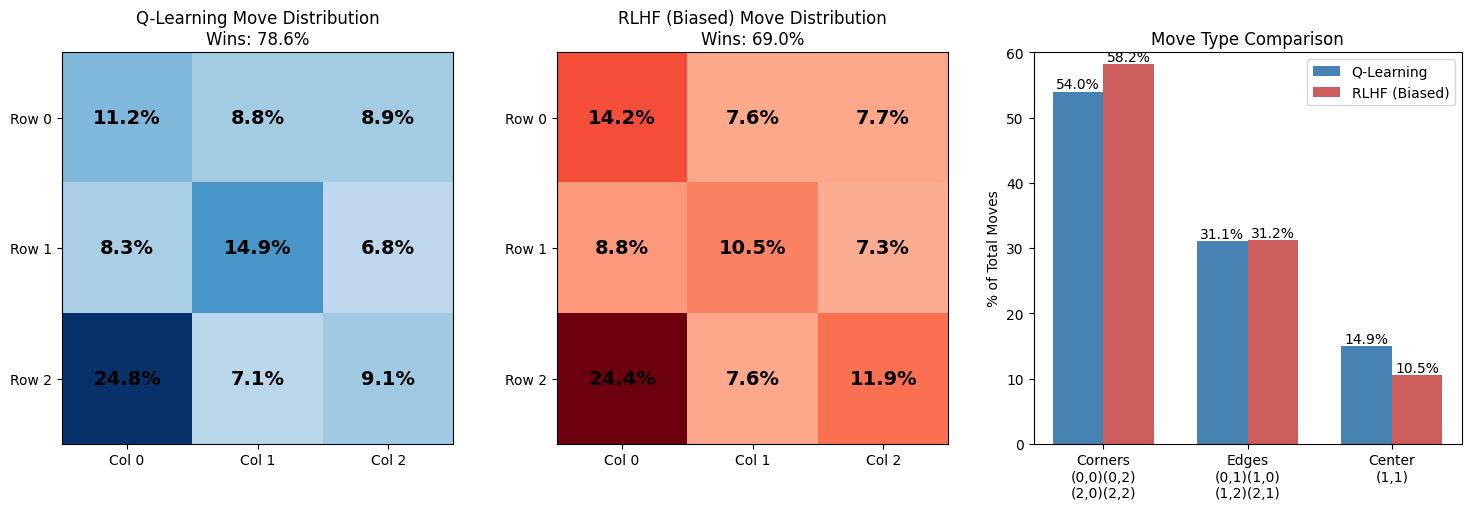


RESULTS SUMMARY

Metric                         Q-Learning   RLHF (Biased)
-------------------------------------------------------
Win Rate                            78.6%           69.0%
Center moves                        14.9%           10.5%
Corner moves                        54.0%           58.2%
Edge moves                          31.1%           31.2%


In [10]:
# compareMoveDitributions is imported from helper.py
# Run the comparison!
q_ai_trained, rlhf_ai_trained = compareMoveDitributions()

## 6 Play Against the AI and Measure Performance

Now that we've seen how different AI approaches work, you can try to experiment more by benchmarking the AIs against each other:
1. **Play a game** against one of the AI opponents
2. **Measure performance** by running automated games between AI players
3. **Run a benchmark** comparing all AI types

In [11]:
# Play a game against the Random AI
# Uncomment the line below to play interactively!

# playAgainstAI(ai_type="random")  # Options: "random", "rule_based", "q_learning", "rlhf"

In [12]:
# Measure performance of a specific AI against Random AI
# This runs automated games without user interaction

results = measurePerformance(ai_type="rule_based", num_games=100, player_ai_type="random")


Measuring rule_based AI performance over 100 games...
Playing against: random AI

  Progress: 10/100 games completed
  Progress: 20/100 games completed
  Progress: 30/100 games completed
  Progress: 40/100 games completed
  Progress: 50/100 games completed
  Progress: 60/100 games completed
  Progress: 70/100 games completed
  Progress: 80/100 games completed
  Progress: 90/100 games completed
  Progress: 100/100 games completed

PERFORMANCE RESULTS: RULE_BASED AI
  Games played: 100
  Opponent: random AI
--------------------------------------------------
  Wins:      86 (86.0%)
  Losses:     2 (2.0%)
  Ties:      12 (12.0%)


In [13]:
# Run a comprehensive benchmark comparing all AI types
# This tests Random AI, Rule-Based AI, and Q-Learning (trained) against a Random opponent

all_results, trained_q_ai = runPerformanceBenchmark(num_games=500, training_games=3000)


COMPREHENSIVE AI PERFORMANCE BENCHMARK
Each AI will play 500 games as X against Random AI (O)


Measuring random AI performance over 500 games...
Playing against: random AI

  Progress: 50/500 games completed
  Progress: 100/500 games completed
  Progress: 150/500 games completed
  Progress: 200/500 games completed
  Progress: 250/500 games completed
  Progress: 300/500 games completed
  Progress: 350/500 games completed
  Progress: 400/500 games completed
  Progress: 450/500 games completed
  Progress: 500/500 games completed

PERFORMANCE RESULTS: RANDOM AI
  Games played: 500
  Opponent: random AI
--------------------------------------------------
  Wins:     297 (59.4%)
  Losses:   155 (31.0%)
  Ties:      48 (9.6%)


Measuring rule_based AI performance over 500 games...
Playing against: random AI

  Progress: 50/500 games completed
  Progress: 100/500 games completed
  Progress: 150/500 games completed
  Progress: 200/500 games completed
  Progress: 250/500 games completed
  Progr